# Installs and imports

In [ ]:
# !pip install sentence_transformers
# !pip install scikit-learn-extra
# # !pip install yellowbrick

In [ ]:
####### Basic #################
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import cm
import matplotlib.pyplot as plt
import re
from collections import defaultdict 
import pickle
import pathlib
import string
from IPython.core import display as ICD

####### Preprocessing & Modeling #################
from sklearn.feature_extraction.text import CountVectorizer
from urllib.parse import urlparse
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score, silhouette_samples
from sentence_transformers import SentenceTransformer


In [ ]:
pd.options.display.max_colwidth = 150

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
file_name = 'Data Scientist Test Data'
metadata_path = f'{file_name}.xlsx'
df = pd.read_excel(metadata_path)
df.columns = map(str.lower, df.columns)
df

,sentence_id,word,sentence,token
0,40389699.0,address,"His mind followed suit, racing along, constructing a plan to prove his theory and more important­ly, to address it.",NaN
1,3bc203fa,address,"Once again, there was too much behind his simple statement for her to address.",NaN
2,c2bb84af,address,"Arakcheev looked at the Emperor from under his brow and, sniffing with his red nose, stepped forward from the crowd as if expecting the Emperor to...",NaN
3,2f1572a2,address,Toby's address was listed as hers.,NaN
4,c9d264e7,address,I just decided it was a fait accompli and we might as well address the situation as best we can.,NaN
...,...,...,...,...
102,f2492dac,rock,"But, unfortunately, I struck my foot on a rock and fell forward into the cold water.",NaN
103,4aa86e43,rock,the concert had great rock bands performing,NaN
104,541aa0fa,rock,her brother was the guitar player of the rock band,NaN
105,97400949.0,rock,"A small rock trickled down, bouncing and skipping before stopping by Dean's shoe—the slight noise was a rumble in the mountain stillness.",NaN


In [ ]:
words = df['word'].unique()
words

array(['address', 'arm', 'fire', 'left', 'rock'], dtype=object)

# EDA 

In [ ]:
for word in words:
    print(f"--------------------------{word}------------------------")
    word_vectorizer = CountVectorizer(ngram_range=(1,1), analyzer='word')
    sparse_matrix = word_vectorizer.fit_transform(df[df.word == word]['sentence'])
    frequencies = sum(sparse_matrix).toarray()[0]

    cm = sns.light_palette("grey", as_cmap=True)
    temp_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency']).sort_values(by="frequency", ascending=False)
    s = temp_df.head(10).style.background_gradient(cmap=cm)
    ICD.display(s)



--------------------------address------------------------


,frequency
address,21
the,19
to,18
and,11
it,6
her,6
in,6
his,6
you,5
as,5


--------------------------arm------------------------


,frequency
the,11
he,9
arm,9
her,9
to,8
around,6
and,4
his,4
arms,4
with,4


--------------------------fire------------------------


,frequency
the,16
fire,12
and,11
fired,9
to,7
in,6
you,5
me,5
she,4
of,4


--------------------------left------------------------


,frequency
left,27
the,25
and,15
to,9
her,7
had,6
of,6
she,6
in,6
it,6


--------------------------rock------------------------


,frequency
the,23
rock,23
and,11
she,8
at,7
of,6
was,5
in,5
his,5
they,4


# Model

In [ ]:
## ALL FUNCTIONS ##

def create_embedding_by_sentence_transformer(embedder, text_list):
    text_embedding = embedder.encode(text_list)
    return text_embedding

def calculate_cosine(matrix):
    distance_matrix = pairwise_distances(matrix, metric='cosine')
    distance_matrix = distance_matrix.astype(np.float64)
    return distance_matrix

def cluster_sentence_by_word(df, word):
    temp_df = df[df.word == word]
    text_embedding = create_embedding_by_sentence_transformer(embedder, temp_df["sentence"].values)

    clustering_model = AgglomerativeClustering(n_clusters=2, distance_threshold=None ,affinity="precomputed",linkage="complete", compute_distances=True)
    d_matrix = calculate_cosine(text_embedding)
    clustering_model.fit(d_matrix)
    cluster_assignment = clustering_model.labels_
    temp_df["token"] = cluster_assignment
    temp_df = temp_df.sort_values("token")
    temp_df = temp_df.drop(columns="sentence_id")

    return temp_df, clustering_model


def plot_dendrogram(word, model, labels, ax, **kwargs):
    ax.set_title(f'Tree of {word}')
    ax.set_xlabel('Indexs from the dataframe')

    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, labels=labels, ax=ax, **kwargs) # , link_color_func=['c', 'm', 'y', 'k']
    

def plot_silhouette(silhouette_vals, y, 
 					colors = cm.tab10,
                    plot_noise = False,
                    title=""
					):
    """
    Plotting silhouette scores for the individual samples of a labelled data set.
    The scores will be grouped according to labels and sorted in descending order.
    The bars are proportional to the score and the color is determined by the label.
    
    silhouette_vals: the silhouette values of the samples
    y:               the labels of the samples
    plot_noise:      boolean, assumes the noise to be labeled with a negative integer
    
    """
    cluster_labels = np.unique(y)
    n_clusters = len(cluster_labels)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels): # generate pairs index, cluster_label
        if (c < 0 and plot_noise == False):
            continue
        c_silhouette_vals = silhouette_vals[y==c] # extracts records with the current cluster label
        c_silhouette_vals.sort() # sort the silhouette vals for the current class
        y_ax_upper += len(c_silhouette_vals)
        color = colors(i / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                edgecolor='none', color=color)
        yticks.append((y_ax_lower + y_ax_upper) / 2)
        y_ax_lower += len(c_silhouette_vals)
        c_silhouette_avg = np.mean(c_silhouette_vals)
        plt.axvline(c_silhouette_avg, #ymin = y_ax_lower, ymax = y_ax_upper,
                    color=color, linestyle="-.")

    silhouette_avg = np.mean(silhouette_vals)
    plt.title(title)
    plt.axvline(silhouette_avg, color="black", linestyle="-.") 
    plt.yticks(yticks, cluster_labels)# + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

Train a model for each word

In [ ]:
choosen_transformer = "sentence-transformers/stsb-roberta-base-v2"
embedder = SentenceTransformer(choosen_transformer)

In [ ]:
word_data_dict = defaultdict(dict)
words = df.word.unique()

In [ ]:
for word in words:
    word_data_dict[word]["embedding"] = create_embedding_by_sentence_transformer(embedder, df[df.word == word]["sentence"].values)

In [ ]:
for word in words:
    df_by_word, clustering_model  = cluster_sentence_by_word(df, word)
    word_data_dict[word]["df"] = df_by_word
    word_data_dict[word]["model"] = clustering_model

Results

In [ ]:
for word in words:
    print(f"--------------------------{word}------------------------")
    temp_df = word_data_dict[word]["df"]
    ICD.display(temp_df)

--------------------------address------------------------


,word,sentence,token
10,address,"You can expand on it if you want to; say get a driver's license in another state, or establish an address.",0
16,address,I will address the dhjan and leave.,0
13,address,The dhjan has granted us permission to address you.,0
11,address,I'll update your address list virtually over the next few years.,0
19,address,"My name is Platon, and the surname is Karataev, he added, evidently wishing to make it easier for Pierre to address him.",0
8,address,You gave your low-life friends my name and address so they could ransack my house and maybe kill someone who got in their way?,0
20,address,"They are as follows: - (1) IIpos ""EXXnvas X6yos b 7rporpeirruK6s, A Hortatory Address to the Greeks.",0
7,address,"They entered, and she looked up at him, afraid to address the fierce warrior.",1
5,address,"She wished to pray but did not dare to, dared not in her present state of mind address herself to God.",1
9,address,"Uneasy, he also realized he had to focus on mopping up the rest of his mess in the mortal world, so he could start to address the underworld.",1


--------------------------arm------------------------


,word,sentence,token
23,arm,"They were fully armed, ready to fight",0
24,arm,both sides armed themselves with grenades.,0
25,arm,The second amendment states that we have the right to bear arms,0
26,arm,"He changed the subject by pointing out Brandon Westlake standing near the boys, his arm about Billy, as with animated motions he seemed to be givi...",0
29,arm,He had no way to arm himself,0
31,arm,"Armed with a rifle, she slowly approached the door",0
33,arm,"The second dealer was moving closer, and she couldn't free herself from the thick arm wrapped around her.",0
35,arm,We must arm our nation for war,0
21,arm,"Reaching down, he placed one arm behind her knees and the other around her back, gently lifting her into his arms.",1
22,arm,"If he would only put an arm around her when they slept, like he used to, she might feel better.",1


--------------------------fire------------------------


,word,sentence,token
36,fire,Had he decided to fire her?,0
54,fire,she aimed the gun and fired.,0
53,fire,alex fired twice more and the bear dropped to the ground.,0
51,fire,i thought i got fired from that job.,0
50,fire,having to fire men who've been with me for years.,0
48,fire,a bullet fired by a french sharpshooter hit him in the fleshy part of his leg.,0
47,fire,she stole his gun and fired without fear,0
44,fire,The French had time to fire three rounds of grapeshot before the hussars got back to their horses.,0
46,fire,he raised his gun and fired at the great beast.,0
41,fire,"Do it, and I fire you.",0


--------------------------left------------------------


,word,sentence,token
57,left,The car was parked on the left side,0
81,left,then there was the money he left to carmen.,0
80,left,she stood on her left foot only,0
79,left,He could play the piano with his left hand only,0
78,left,It left her calm.,0
77,left,Princess Mary was left alone.,0
74,left,Not one of the bees so much as looked at those in her left hand.,0
73,left,She had dirt on her left shoe,0
71,left,The cook was afraid of him and left everything in one corner.,0
68,left,Her sister was left handed,0


--------------------------rock------------------------


,word,sentence,token
84,rock,"She slid down the rock and joined them, casting a sour look at Bordeaux as she brushed by him.",0
102,rock,"But, unfortunately, I struck my foot on a rock and fell forward into the cold water.",0
101,rock,"After examining a rock for ants or other insects, she leaned against it, drawing in the clean smell of the forest.",0
100,rock,In the background were the beautiful layered mountains of the White Rock Wildlife Management.,0
99,rock,A large rock beside the road provided a place to rest while she listened for vehicles.,0
105,rock,"A small rock trickled down, bouncing and skipping before stopping by Dean's shoe—the slight noise was a rumble in the mountain stillness.",0
93,rock,They stopped at a rock wall.,0
92,rock,She glanced around at the rock outcroppings.,0
95,rock,He removed his hand and they moved back against the rock wall of lava that swirled over them.,0
90,rock,"When at last they arrived at the trail's end, Westlake parked, placed a rock behind his wheel, and held out his polka-dot umbrella.",0


Plots the dendrogram to simulate how the clustering works.

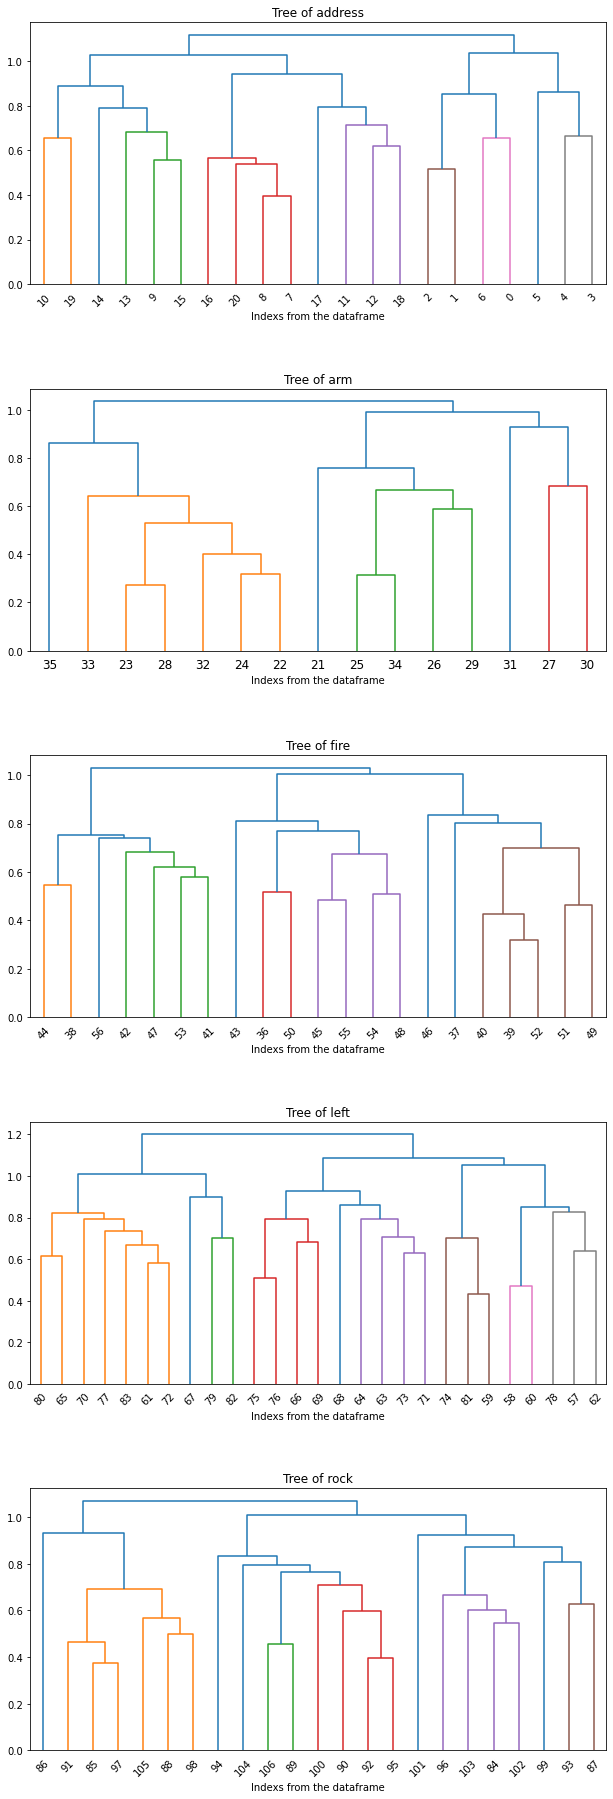

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

words = list(word_data_dict.keys())
for ax, word in zip(axes.flatten(), words):
    labels = word_data_dict[word]["df"].index
    clustering_model =  word_data_dict[word]["model"]
    plot_dendrogram(word, clustering_model, labels, ax, truncate_mode="level", p=20)

Dimension reduction to visualize the results of the model.

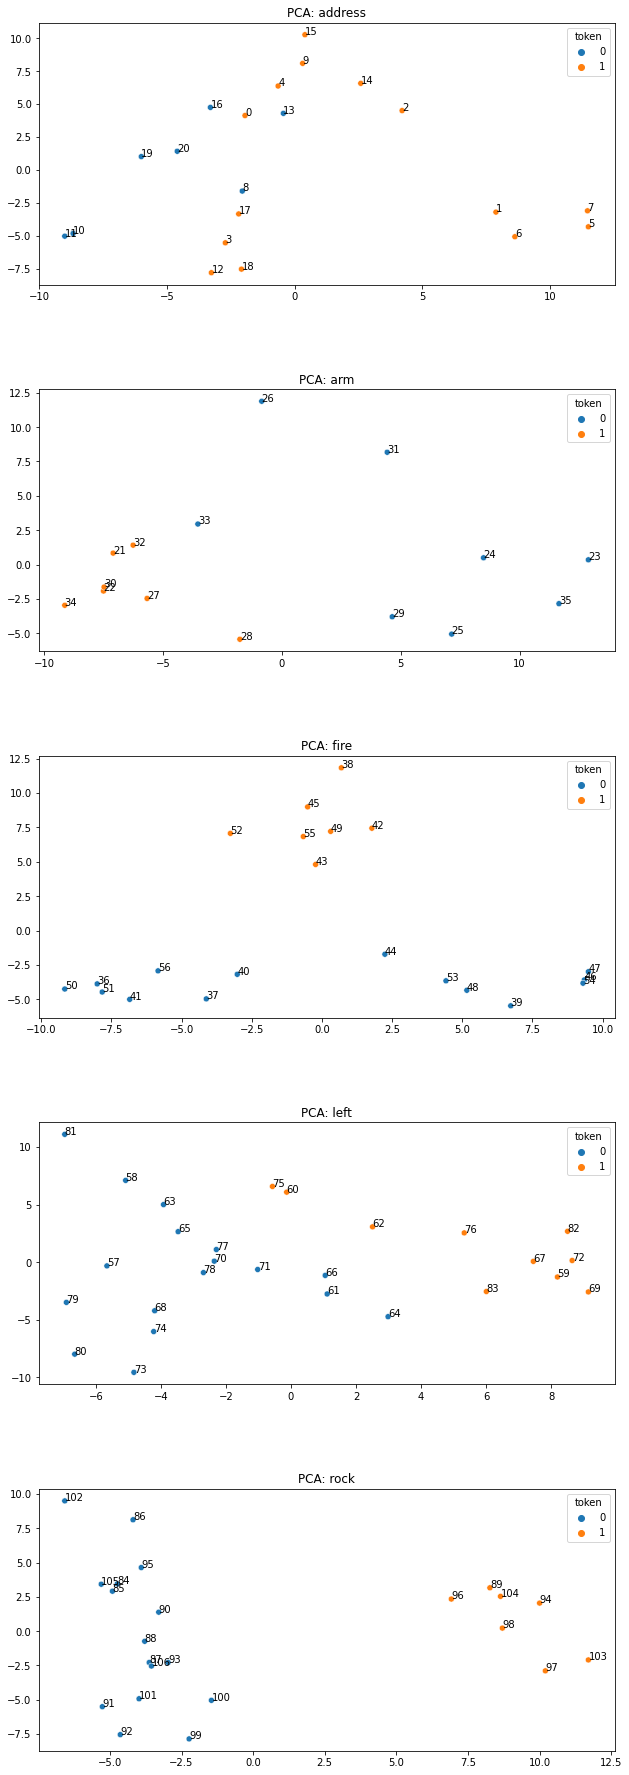

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 30))
fig.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

words = list(word_data_dict.keys())
for ax, word in zip(axes.flatten(), words):
    ax.set_title(f'PCA: {word}')
    pca = PCA(n_components=2)
    Xt = pca.fit_transform(word_data_dict[word]["embedding"])
    sns.scatterplot(x=Xt[:,0], y=Xt[:,1], hue=word_data_dict[word]["df"].sort_index().token, ax=ax);

    for i, index in enumerate(word_data_dict[word]["df"].sort_index().index):
        ax.annotate(index, (Xt[i,0], Xt[i,1]))

The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 

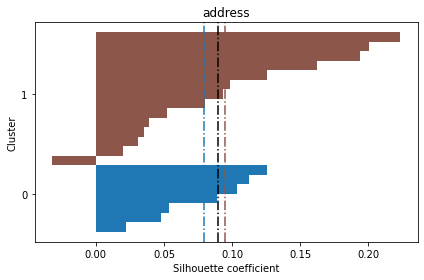

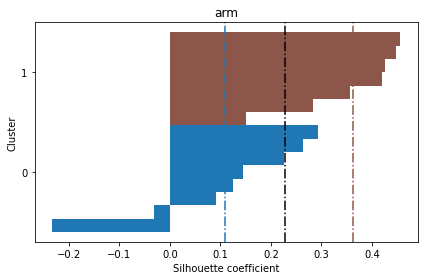

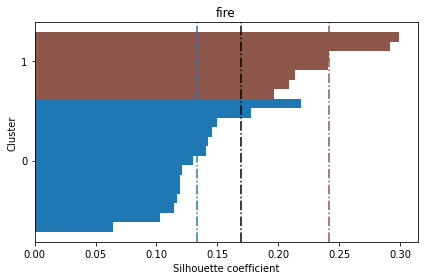

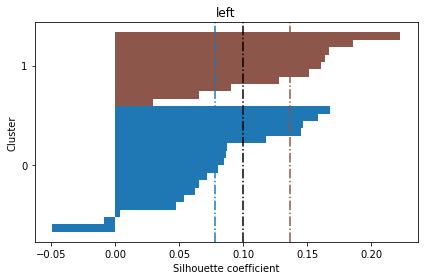

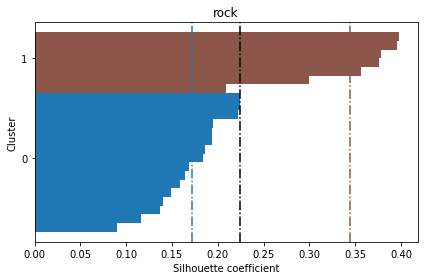

In [ ]:
for word in words:
    silhouette_vals = silhouette_samples(word_data_dict[word]["embedding"], word_data_dict[word]["df"].sort_index().token, metric='cosine')
    plot_silhouette(silhouette_vals, word_data_dict[word]["df"].sort_index().token, title=word)